In [1]:
#Initiate libraries needed for script
import numpy as np
from numpy import genfromtxt
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as matplotlib
import seaborn as sns
import matplotlib.cm as cm
from numpy import linspace
import copy
import statistics
import pandas as pd
import matplotlib.ticker as ticker

#functions used in this script:

#Average three readings (of OD) for a single value
def AVG(y1, y2, y3):
    #Average
    i = 0
    new = []
    while i < len(y1):
        new.append((y1[i]+y2[i]+y3[i])/3)
        i = i+1
    return new

#Calculate the error of three readings (of OD)
def error_calc(y1, y2, y3):
    i = 0 
    error = []
    while i < len(y1):
        error.append(statistics.stdev([y1[i],y2[i],y3[i]]))
        i = i+1
    return error

#Converts the absorbance data into useable pandas format
def csv_to_array_abs(csv_file):
    my_data = genfromtxt(csv_file,        # Feed it the variable
                         delimiter=',',   # Commas seperate the terms
                         skip_header=1,   # Ignore the start, currently the first 8 lines
                         dtype="float",
                         usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21)) # A faff, but ignores the 1st column
    return my_data
#Splits the master pandas frame from csv_to_array_abs to individual polymer and membrane variables
def csv_to_pandas(r1,r2,r3):
    ###
    avg = AVG(r1,r2,r3)
    avg_df = pd.DataFrame(avg, columns=['avg'])
    
    err = error_calc(r1,r2,r3)
    err_df = pd.DataFrame(err, columns=['err'])
    
    df = pd.concat([avg_df, err_df], axis=1)
    
    return df

#Calculate the normalised solubilisation (solubilisation efficiency) for each condition and polymer 
def solub_calc(membrane, polymer1, polymer2, polymer3):
#from ConcControl (Excel spreadsheet for each membrane), fully solubilised can be thought of as Abs = 0.579625 (0ug/mL lipid)
#so can normalise solubilisation from membrane abs to this value to get % solubilised
#where 100% is around 0.579625, and 0% is membrane
    fully_sol = 0.580 #(rounded)
    i = 0
    norm = []
    norm_err = []
    #For each condition tested:
    while i < len(membrane):
        #for each repeat of polymer and condition (i.e. reading 1,2,3)
        #Follows from this point the normalisation equation (% = x-max/min-max)
        temp1_a = (polymer1[i] - membrane[i])
        temp1_b = (polymer2[i] - membrane[i])
        temp1_c = (polymer3[i] - membrane[i])
        
        temp2_a = (temp1_a/(fully_sol-membrane[i]))
        temp2_b = (temp1_b/(fully_sol-membrane[i]))
        temp2_c = (temp1_c/(fully_sol-membrane[i]))
        
    #Does this for each polymer and condition (in triplicate), then calculates avg + error for the normalised value
        temp_avg = ((temp2_a + temp2_b + temp2_c)/3)
        temp_err = statistics.stdev([temp2_a, temp2_b, temp2_c])
        if temp_avg < 0:
            norm.append(0)
            norm_err.append(0)
        else:
            norm.append(temp_avg*100)
            norm_err.append(temp_err*100)
        i = i+1
        
    return norm, norm_err

#As DLS .csv is in a different format to the OD .csv, another file reader is required
def csv_to_array_DLS(csv_file):
    my_data = genfromtxt(csv_file,        # Feed it the variable
                         skip_header=2,   # Ignore the start, currently the first 1 lines
                         dtype="float") # A faff, but ignores the 1st column
    return my_data

#Standard colours used within the thesis
colors = [sns.xkcd_rgb["black"], #0, black
          sns.xkcd_rgb["cerulean"], #1 blue
          sns.xkcd_rgb["moss green"], #2 dark green
          sns.xkcd_rgb["rust"], #3 dark red
          sns.xkcd_rgb["slate"], #4 slate/grey-blue
          sns.xkcd_rgb["mustard"], #5 yellow
          sns.xkcd_rgb["tangerine"], # 6 tangerine ***** this is for SMA 3:1
          sns.xkcd_rgb["coral"], #7 pink-red ***** This is for SMA 2:1
          sns.xkcd_rgb["grass"], #8 grass (brighter green)***** This is for DIBMA
          sns.xkcd_rgb["bright blue"], #9  bright blue *****This is for PMA
          sns.xkcd_rgb["olive green"] #10 olive green
         ]
#standard plotting style used within this thesis.
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
#pH conditions tested
pH = [3, 4, 5, 5.5, 5.8, 6, 6.2, 6.4, 6.5, 6.6, 6.8, 7,
      7.2, 7.4, 7.5, 7.6, 7.8, 8, 8.5, 9, 10]



#Reads in OD as a 'master-file' which is then split into polymer as numbered below
#0-3 is SMA 3:1
#4-6 is SMA 2:1
#7-9 is DIBMA
#10-12 is PMA
#13-5 is mebrane only


#OD is recorded twice: First the initial (membrane only) instance, this is used for the initial (maimum) OD for norm.
#DMPC
csv_0 = csv_to_array_abs("pH_DMPC_compiled_0.csv")

SMA31_DMPC_0 = csv_to_pandas(csv_0[0],csv_0[1],csv_0[2])
SMA21_DMPC_0 = csv_to_pandas(csv_0[3],csv_0[4],csv_0[5])
DIBMA_DMPC_0 = csv_to_pandas(csv_0[6],csv_0[7],csv_0[8])
PMA_DMPC_0 = csv_to_pandas(csv_0[9],csv_0[10],csv_0[11])

#Second reading is after 1 hour incubation with the polymer, as described in the thesis.
csv_1 = csv_to_array_abs("pH_DMPC_compiled_1.csv")

SMA31_DMPC_1 = csv_to_pandas(csv_1[0],csv_1[1],csv_1[2])
SMA21_DMPC_1 = csv_to_pandas(csv_1[3],csv_1[4],csv_1[5])
DIBMA_DMPC_1 = csv_to_pandas(csv_1[6],csv_1[7],csv_1[8])
PMA_DMPC_1 = csv_to_pandas(csv_1[9],csv_1[11],csv_1[11])

#The average membrane value (per membrane type, and condition of pH/salt etc) is averaged, for use in normalisation
memb_DMPC_avg = AVG(SMA31_DMPC_0['avg'], SMA21_DMPC_0['avg'], DIBMA_DMPC_0['avg'])
#Error too for plotting
memb_DMPC_err = error_calc(SMA31_DMPC_0['err'], SMA21_DMPC_0['err'], DIBMA_DMPC_0['err'])

#Calculating the solubilisation efficiency for plotting
SMA31_DMPC_sol, SMA31_DMPC_err = solub_calc(SMA31_DMPC_0['avg'],csv_1[0],csv_1[1],csv_1[2])
SMA21_DMPC_sol, SMA21_DMPC_err = solub_calc(SMA21_DMPC_0['avg'],csv_1[3],csv_1[4],csv_1[5])
DIBMA_DMPC_sol, DIBMA_DMPC_err = solub_calc(DIBMA_DMPC_0['avg'],csv_1[6],csv_1[7],csv_1[8])
PMA_DMPC_sol, PMA_DMPC_err = solub_calc(PMA_DMPC_0['avg'],csv_1[9],csv_1[11],csv_1[11])


#PCPG
#Same again for the PC:PG membrane samples!

csv_0 = csv_to_array_abs("pH_PCPG_compiled_0.csv")

SMA31_PCPG_0 = csv_to_pandas(csv_0[0],csv_0[1],csv_0[2])
SMA21_PCPG_0 = csv_to_pandas(csv_0[3],csv_0[4],csv_0[5])
DIBMA_PCPG_0 = csv_to_pandas(csv_0[6],csv_0[7],csv_0[8])
PMA_PCPG_0 = csv_to_pandas(csv_0[9],csv_0[10],csv_0[11])


csv_1 = csv_to_array_abs("pH_PCPG_compiled_1.csv")

SMA31_PCPG_1 = csv_to_pandas(csv_1[0],csv_1[1],csv_1[2])
SMA21_PCPG_1 = csv_to_pandas(csv_1[3],csv_1[4],csv_1[5])
DIBMA_PCPG_1 = csv_to_pandas(csv_1[6],csv_1[7],csv_1[8])
PMA_PCPG_1 = csv_to_pandas(csv_1[9],csv_1[11],csv_1[11])

memb_PCPG_avg = AVG(SMA31_PCPG_0['avg'], SMA21_PCPG_0['avg'], DIBMA_PCPG_0['avg'])
memb_PCPG_err = error_calc(SMA31_PCPG_0['err'], SMA21_PCPG_0['err'], DIBMA_PCPG_0['err'])

SMA31_PCPG_sol, SMA31_PCPG_err = solub_calc(SMA31_PCPG_0['avg'],csv_1[0],csv_1[1],csv_1[2])
SMA21_PCPG_sol, SMA21_PCPG_err = solub_calc(SMA21_PCPG_0['avg'],csv_1[3],csv_1[4],csv_1[5])
DIBMA_PCPG_sol, DIBMA_PCPG_err = solub_calc(memb_PCPG_avg,csv_1[6],csv_1[7],csv_1[8])
PMA_PCPG_sol, PMA_PCPG_err = solub_calc(PMA_PCPG_0['avg'],csv_1[9],csv_1[11],csv_1[11])

Done Abs


In [3]:
#DLS import, separated for clarity
DLS_DMPC = pd.read_csv("pH_DMPC_vals.csv", header = 0,
                          names= ["pH", "3:1 loc", "3:1 err", "2:1 loc", "2:1 err",
                                   "DIBMA loc", "DIBMA err", "PMA loc", "PMA err"])

DLS_PCPG = pd.read_csv("pH_PCPG_vals.csv", header = 0,
                          names= ["pH", "3:1 loc", "3:1 err", "2:1 loc", "2:1 err",
                                   "DIBMA loc", "DIBMA err", "PMA loc", "PMA err"])
print("Done DLS")

Done DLS


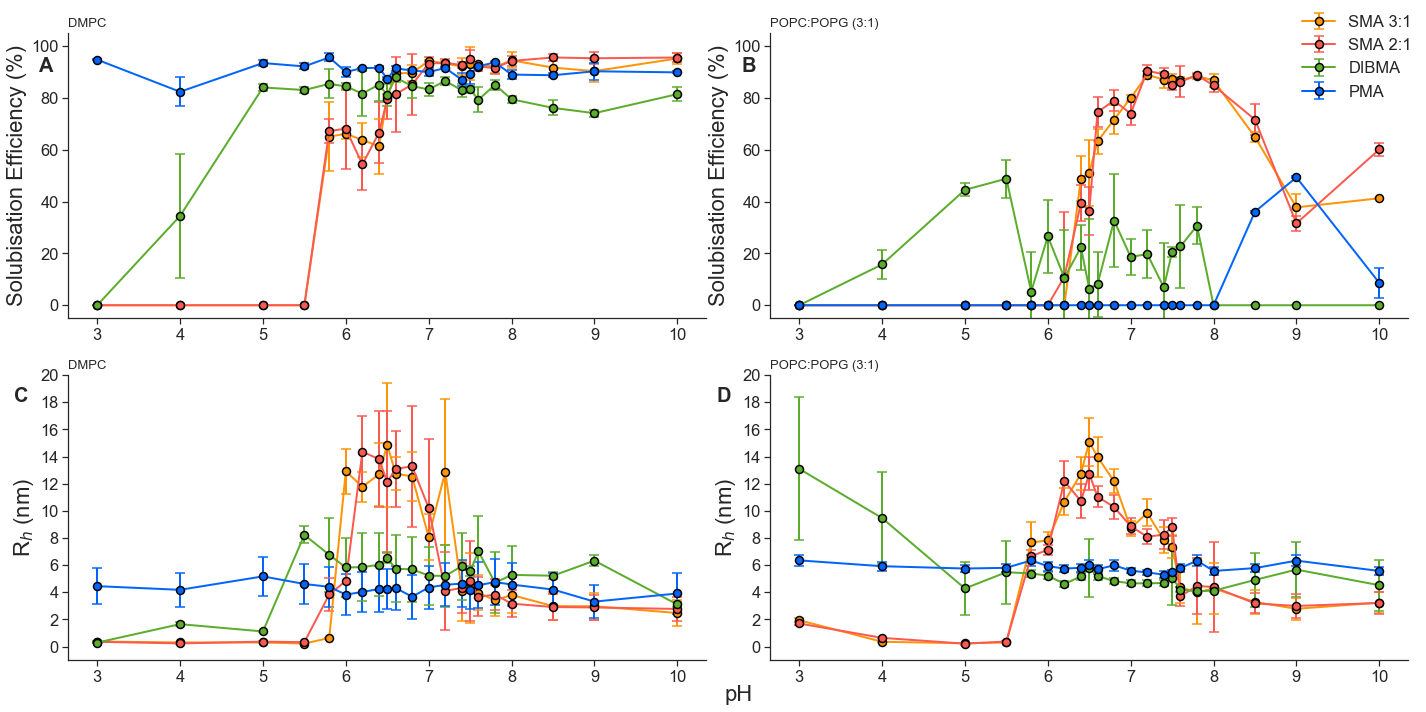

In [18]:
#Now we plot!

#i = 6 denotes the colour counter for the standard colours, 6 is SMA 3:1, 7 is SMA 2:1 etc
i = 6

#The figure is composed of 4 individual graphs, two for the OD (DMPC and PC:PG) and two for the DLS data (DMPC and PC:PG)
fig, axs = plt.subplots(2, 2, figsize=(20, 10), frameon = True)
#Axes are numbered in a 2x2 grid (or matrix), [0,0] denotes the top left, [0,1] the top right, etc
#First in this graph is DMPC, in the top left (so [0,0])
#The values plotted here are pH (the condition tested), the polymer (SMA31_DMPC_sol), and the error of the polymer
#The other variables are differnt cosmetic changes for a pretty picture, such as color = colors[i] 
#for my orange colour for SMA 3:1
axs[0,0].errorbar(pH, SMA31_DMPC_sol, yerr = SMA31_DMPC_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i = i+1
axs[0,0].errorbar(pH, SMA21_DMPC_sol, yerr = SMA21_DMPC_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i = i+1
axs[0,0].errorbar(pH, DIBMA_DMPC_sol, yerr = DIBMA_DMPC_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i = i+1
axs[0,0].errorbar(pH, PMA_DMPC_sol, yerr = PMA_DMPC_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
#a y limit is set here to ensure that all soubilisation efficiencies are standardised in the thesis from 0-100,
#-5 and 105 were chosen to allow for enough room for all error bars as needed
axs[0,0].set_ylim(-5,105)

#Now we begin the PC:PG OD plot, in the top right
#resetting the colour counter for the next round of polymer
i = 6
axs[0,1].errorbar(pH, SMA31_PCPG_sol, yerr = SMA31_PCPG_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i = i+1
axs[0,1].errorbar(pH, SMA21_PCPG_sol, yerr = SMA21_PCPG_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i = i+1
axs[0,1].errorbar(pH, DIBMA_PCPG_sol, yerr = DIBMA_PCPG_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i = i+1
axs[0,1].errorbar(pH, PMA_PCPG_sol, yerr = PMA_PCPG_err, color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
axs[0,1].set_ylim(-5,105)


#DLS
#Same principles apply here, but instead we're plotting DLS data (the bottom left [1,0])
i = 6
axs[1,0].errorbar(pH, DLS_DMPC["3:1 loc"], yerr = DLS_DMPC["3:1 err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i= i+1
axs[1,0].errorbar(pH, DLS_DMPC["2:1 loc"], yerr = DLS_DMPC["2:1 err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i= i+1
axs[1,0].errorbar(pH, DLS_DMPC["DIBMA loc"], yerr = DLS_DMPC["DIBMA err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
i= i+1
axs[1,0].errorbar(pH, DLS_DMPC["PMA loc"], yerr = DLS_DMPC["PMA err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8)
#As the particles are no more than 20 nm in radius, including errors this scale is from -1 to 20. Again for standard axis
axs[1,0].set_ylim(-1,20)
#Because it is a smaller range, this line ensures only intervals of two are plotted (0,2,4,6 etc)
axs[1,0].yaxis.set_major_locator(ticker.MultipleLocator(2))

#final one!
i = 6
axs[1,1].errorbar(pH, DLS_PCPG["3:1 loc"], yerr = DLS_PCPG["3:1 err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8, label = "SMA 3:1")
i= i+1
axs[1,1].errorbar(pH, DLS_PCPG["2:1 loc"], yerr = DLS_PCPG["2:1 err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8, label = "SMA 2:1")
i= i+1
axs[1,1].errorbar(pH, DLS_PCPG["DIBMA loc"], yerr = DLS_PCPG["DIBMA err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8, label = "DIBMA")
i= i+1
axs[1,1].errorbar(pH, DLS_PCPG["PMA loc"], yerr = DLS_PCPG["PMA err"], color = colors[i], capthick = 1, capsize = 5,
             lw = 2,  marker = "o", markeredgecolor = colors[0], markerfacecolor = colors[i],
             markeredgewidth = 1.5, markersize = 8, label = "PMA")
axs[1,1].set_ylim(-1,20)
axs[1,1].yaxis.set_major_locator(ticker.MultipleLocator(2))

#Now that the data has been plotted, it is time to label all the graphs

#This puts a title on each of the four graphs, to show which membrane type is being examined
#Again, this is standardised throughout the thesis
axs[0,0].set_title("DMPC", fontsize = 13, loc = 'left')
axs[0,1].set_title("POPC:POPG (3:1)", fontsize = 13, loc = 'left')
axs[1,0].set_title("DMPC", fontsize = 13, loc = 'left')
axs[1,1].set_title("POPC:POPG (3:1)", fontsize = 13, loc = 'left')

#These label the graph y axis for the four plots, 2 for OD (solubilisation efficiency) and 2 for DLS (hydrodynamic radius)
axs[0,0].set_ylabel("Solubisation Efficiency (%)", fontsize = 22)
axs[0,1].set_ylabel("Solubisation Efficiency (%)", fontsize = 22)
axs[1,0].set_ylabel("R$_{h}$ (nm)", fontsize = 22)
axs[1,1].set_ylabel("R$_{h}$ (nm)", fontsize = 22)

#Labelling A-D for easy reporting in the thesis
axs[0,0].text(x = 2.3, y = 90, s = "A", weight = "bold", fontsize = 20)
axs[0,1].text(x = 2.3, y = 90, s = "B", weight = "bold", fontsize = 20)
axs[1,0].text(x = 2, y = 18, s = "C", weight = "bold", fontsize = 20)
axs[1,1].text(x = 2, y = 18, s = "D", weight = "bold", fontsize = 20)

#As all axis are changing with pH conditions, a single, large, label is needed here
axs[1,1].text(x = 2.1, y = -4, s = "pH", fontsize = 22)
#This puts a legend for the polymer colours in each top right corner
fig.legend(frameon = False)
#tidies up the plotting
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.1)
#makes it pretty be removing the top and right unused axis
sns.despine()
#Saves it
#plt.savefig('Abs_DLS_pH.png', format='png', dpi=300, bbox_inches="tight")
#Shows it
plt.show()